### Look into https://github.com/maartenbreddels/ipyvolume for plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import GPy
#%matplotlib widget
%matplotlib notebook

### Plotting code from https://github.com/krasserm/bayesian-machine-learning/blob/master/gaussian_processes_util.py

In [2]:
# from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

# def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
#     X = X.ravel()
#     mu = mu.ravel()
#     uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
#     plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
#     plt.plot(X, mu, label='Mean')
#     for i, sample in enumerate(samples):
#         plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
#     if X_train is not None:
#         plt.plot(X_train, Y_train, 'rx')
#     plt.legend()

# def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
#     ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
#     ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
#     ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
#     ax.set_title(title)

In [3]:
vsp_input = pd.read_csv('../../Data/vsp_input.tsv', sep='\t',index_col=0)
vsp_input.head()

,Gene.description,AvgChrs,AT2_18M_F10,WSU_Old,Gene start (bp),Gene end (bp),gene length
Gene.names,,,,,,,
0610037L13Rik,RIKEN cDNA 0610037L13 gene,3.689387,4.016506,23.808293,107889813,107899384,9571
1810009A15Rik,RIKEN cDNA 1810009A15 gene,18.144712,0.000000,23.182809,8888853,8890881,2028
2310011J03Rik,RIKEN cDNA 2310011J03 gene,9.614556,4.487340,23.487317,80318254,80320537,2283
2610301B20Rik,RIKEN cDNA 2610301B20 gene,3.069562,4.998258,17.000000,10874498,10899425,24927
2810006K23Rik,RIKEN cDNA 2810006K23 gene,4.818884,1.865742,17.000000,124328089,124341844,13755


In [4]:
all_genes = pd.read_csv('../../Data/rna_seq_cov.tsv',sep='\t',index_col=0,).iloc[:,[1,5,-1]]
all_genes.head()

,AvgChrs,AT2_18M_F10,gene length
MGI.symbol,,,
Gnai3,2.675624,7.126699,38866
Cdc45,15.191392,1.091367,31540
Narf,10.993152,4.224477,18603
Cav2,5.115437,5.937759,7930
Klf6,12.048712,6.626275,8912


In [5]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.5

np.random.seed(1)
msk = np.random.rand(len(all_genes)) < data_percent
train = all_genes[msk]
test = all_genes[~msk]

In [6]:
chrm1 = train[train['AvgChrs']<=1]
chrm1_test = test[test['AvgChrs']<=1]

In [7]:
vsp_chrm1 = vsp_input[vsp_input['AvgChrs']<=1]

In [8]:
chrm1.head()

,AvgChrs,AT2_18M_F10,gene length
MGI.symbol,,,
Ddx18,0.621884,4.078079,14154
Nab1,0.268473,6.310246,43385
Elf3,0.691946,6.529142,4993
Tbc1d8,0.201692,6.070121,107263
Ncstn,0.880302,6.509513,16782


In [9]:
chrm1_test.head()

,AvgChrs,AT2_18M_F10,gene length
MGI.symbol,,,
Cnnm3,0.186830,5.231141,16370
Lman2l,0.186383,5.387627,25400
Rrp15,0.955304,2.544479,28380
Rgs20,0.025528,0.000000,160709
Cnot11,0.202284,4.351779,11897


In [10]:
vsp_chrm1.head()

,Gene.description,AvgChrs,AT2_18M_F10,WSU_Old,Gene start (bp),Gene end (bp),gene length
Gene.names,,,,,,,
Acadl,"acyl-Coenzyme A dehydrogenase, long-chain",0.341978,7.217256,28.021149,66830839,66863277,32438
Acbd3,acyl-Coenzyme A binding domain containing 3,0.924634,5.820596,24.807548,180726043,180754204,28161
Acsl3,acyl-CoA synthetase long-chain family member 3,0.402527,5.640054,17.000000,78657825,78707743,49918
Actr1b,"ARP1 actin-related protein 1B, centractin beta",0.187783,6.712477,25.467643,36698114,36714422,16308
Actr3,ARP3 actin-related protein 3,0.641597,7.504811,26.892912,125392905,125435727,42822


In [11]:
#Subset data into different partitions to test how much data the GP needs
data_percent = 0.80

np.random.seed(1)
msk = np.random.rand(len(vsp_chrm1)) < data_percent
vsp_chrm1_train = vsp_chrm1[msk]
vsp_chrm1_test = vsp_chrm1[~msk]

In [12]:
vsp_chrm1_train.head()

,Gene.description,AvgChrs,AT2_18M_F10,WSU_Old,Gene start (bp),Gene end (bp),gene length
Gene.names,,,,,,,
Acadl,"acyl-Coenzyme A dehydrogenase, long-chain",0.341978,7.217256,28.021149,66830839,66863277,32438
Acbd3,acyl-Coenzyme A binding domain containing 3,0.924634,5.820596,24.807548,180726043,180754204,28161
Acsl3,acyl-CoA synthetase long-chain family member 3,0.402527,5.640054,17.000000,78657825,78707743,49918
Actr1b,"ARP1 actin-related protein 1B, centractin beta",0.187783,6.712477,25.467643,36698114,36714422,16308
Actr3,ARP3 actin-related protein 3,0.641597,7.504811,26.892912,125392905,125435727,42822


In [13]:
pos_train = np.array(vsp_chrm1_train['AvgChrs'])
rna_train = np.array(vsp_chrm1_train['AT2_18M_F10'])
X = np.stack((pos_train,rna_train),axis=1)
protein_train = np.array(vsp_chrm1_train['WSU_Old'])

#Kernel definition
kernel = RBF([10,10])

#Initialize gp regressor
#alpha is noise parameter (nugget value) diagonal noise matrix? deafult 1e-10
gp = GaussianProcessRegressor(kernel=kernel, alpha = 1e-5, normalize_y=True,n_restarts_optimizer=15)
#gp = GaussianProcessRegressor(kernel=kernel, alpha = 1e-5,n_restarts_optimizer=15)

#Fit gp regressor with observation points
gp.fit(X, protein_train)

x1_test = np.array(vsp_chrm1_test['AvgChrs'])
x2_test = np.array(vsp_chrm1_test['AT2_18M_F10'])
X_test = np.stack((x1_test,x2_test),axis=1)
protein_truth = np.array(vsp_chrm1_test['WSU_Old'])

#Prediction
y_pred, MSE = gp.predict(X_test, return_std=True)

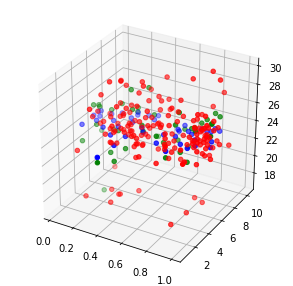

In [14]:
gx = x1_test.reshape(-1,1)
gy = x2_test.reshape(-1,1)
mu = y_pred.reshape(-1,1)
X_train = X
Y_train = protein_train

fig1 = plt.figure()
fig1.set_size_inches((5,5))
ax = fig1.add_subplot(111, projection='3d')
#ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(X_train[:,0], X_train[:,1], Y_train, c='r')
ax.scatter(x1_test,x2_test,y_pred,c='b')
ax.scatter(x1_test,x2_test,protein_truth,c='g')

Text(0, 0.5, 'Protein Level')

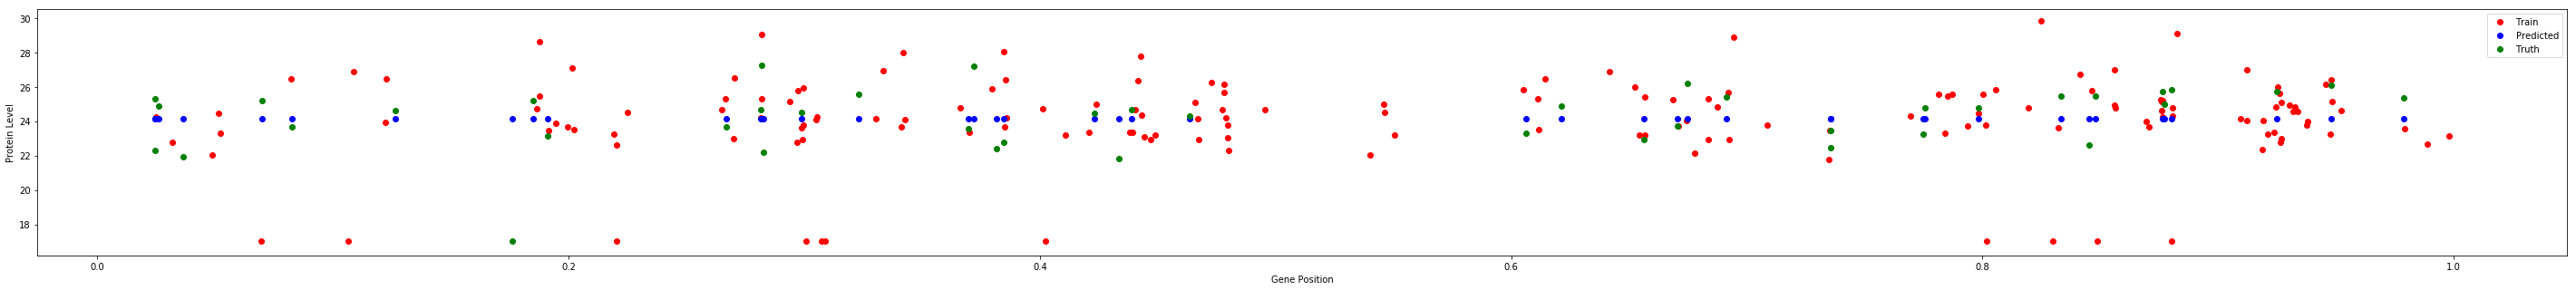

In [15]:
#plt.close('all')
fig1 = plt.figure()
fig1.set_size_inches((50,5))
ax = fig1.add_subplot(111)
#ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
ax.scatter(X_train[:,0], Y_train, c='r',label='Train')
ax.scatter(x1_test,y_pred,c='b',label='Predicted')
ax.scatter(x1_test,protein_truth,c='g',label='Truth')
ax.legend()
ax.set_xlabel('Gene Position')
ax.set_ylabel('Protein Level')

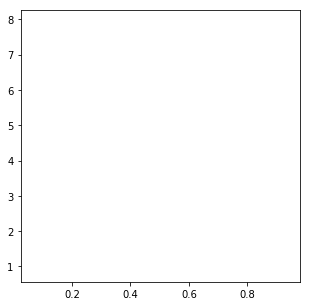

In [16]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.pcolormesh(x1_test.reshape(-1,1), x2_test.reshape(-1,1), y_pred.reshape(-1,1))

In [17]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as pl
""" This is code for simple GP regression. It assumes a zero mean GP Prior """

# This is the true unknown function we are trying to approximate
f = lambda x: np.sin(0.9*x).flatten()
#f = lambda x: (0.25*(x**2)).flatten()

# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/kernelParameter) * sqdist)

In [18]:
s = 0.00005    # noise variance.
X = np.array(vsp_chrm1_train['AvgChrs']).reshape(-1,1)
Y = np.array(vsp_chrm1_train['WSU_Old'])
cov = kernel(X,X)
L = np.linalg.cholesky(cov + s*np.eye(len(X)))

X_test = np.array(vsp_chrm1_test['AvgChrs']).reshape(-1,1)
protein_truth = np.array(vsp_chrm1_test['WSU_Old'])

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, X_test))
mu = np.dot(Lk.T, np.linalg.solve(L, Y))

# compute the variance at our test points.
K_ = kernel(X_test, X_test)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

np.mean((protein_truth - mu)**2)

3.1607278445544993

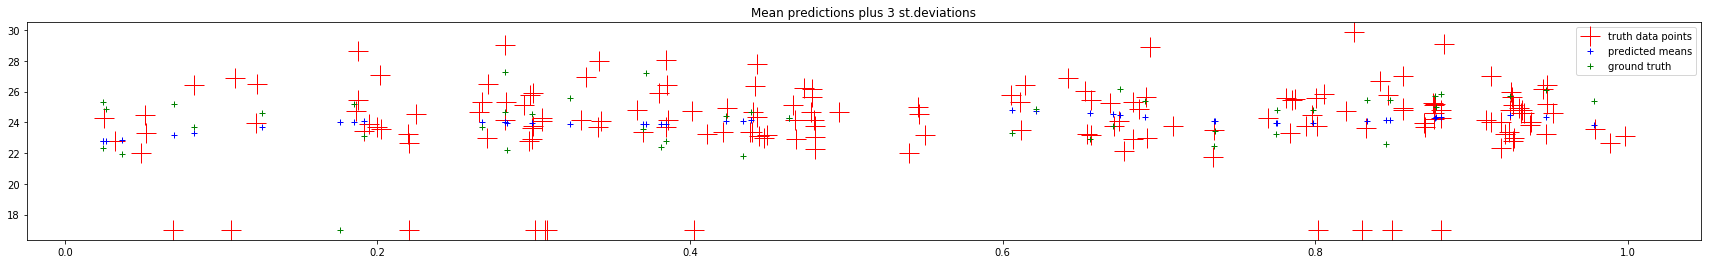

In [19]:
# PLOTS:
fig1 = pl.figure()
fig1.set_size_inches((30,4))
ax = fig1.add_subplot(111)
ax.plot(X, Y, 'r+', ms=20, label='truth data points') #truth values that we are given
#pl.gca().fill_between(X_test.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(X_test, mu, 'b+', lw=1, label='predicted means') #mean values of prediction
pl.plot(X_test, protein_truth, 'g+',label='ground truth')#what the test values should be
pl.title('Mean predictions plus 3 st.deviations')
ax.plot()
ax.legend()

In [20]:
# pos_train = np.array(vsp_chrm1_train['AvgChrs'])
# rna_train = np.array(vsp_chrm1_train['AT2_18M_F10'])
# X = np.stack((pos_train,rna_train),axis=1)
# protein_train = np.array(vsp_chrm1_train['WSU_Old'])

# #Kernel definition
# kernel = RBF([10,10])

# #Initialize gp regressor
# #alpha is noise parameter (nugget value) diagonal noise matrix? deafult 1e-10
# gp = GaussianProcessRegressor(kernel=kernel, alpha = 1e-5, normalize_y=True,n_restarts_optimizer=15)
# #gp = GaussianProcessRegressor(kernel=kernel, alpha = 1e-5,n_restarts_optimizer=15)

# #Fit gp regressor with observation points
# gp.fit(X, protein_train)

# x1_test = np.array(vsp_chrm1_test['AvgChrs'])
# x2_test = np.array(vsp_chrm1_test['AT2_18M_F10'])
# X_test = np.stack((x1_test,x2_test),axis=1)
# protein_truth = np.array(vsp_chrm1_test['WSU_Old'])

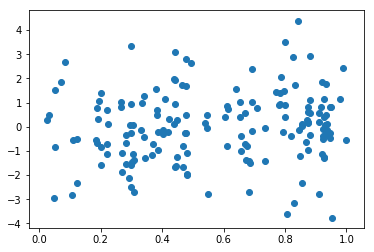

In [21]:
X_pos = np.array(vsp_chrm1_train['AvgChrs']).reshape(-1,1)
Y_rna = np.array(vsp_chrm1_train['AT2_18M_F10']).reshape(-1,1)
Y_rna = Y_rna - Y_rna.mean()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_pos,Y_rna)

In [22]:
m = GPy.models.GPRegression(X_pos, Y_rna)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


 /home/balchlab/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


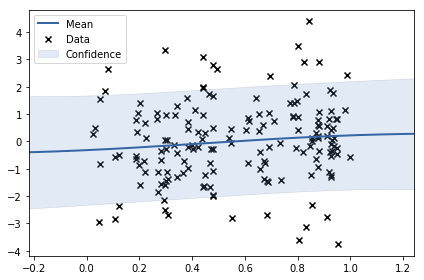

In [23]:
_ = m.plot()

In [24]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed

In [25]:
m.rbf.lengthscale = 1
m.Gaussian_noise.variance = 1
m.rbf.variance = 1

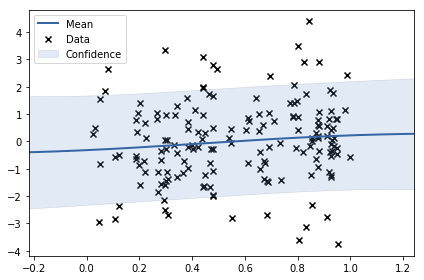

In [26]:
_ = m.plot()

In [27]:
pos_train = np.array(vsp_chrm1_train['AvgChrs'])
rna_train = np.array(vsp_chrm1_train['AT2_18M_F10'])
X2 = np.stack((pos_train,rna_train),axis=1)
Y2 = np.array(vsp_chrm1_train['WSU_Old']).reshape(-1,1)
Y2 = Y2 - Y2.mean()

In [28]:
ker = GPy.kern.RBF(input_dim=2, ARD=True)

m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot(cmap=cmhot)

NameError: name 'cmhot' is not defined

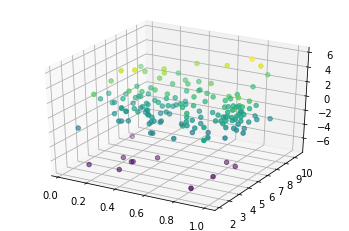

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmhot = plt.get_cmap("viridis")
ax.scatter(X2[:,0],X2[:,1],Y2.squeeze(),c=Y2.squeeze(),cmap = cmhot)

In [31]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [32]:
x1_test = np.array(vsp_chrm1_test['AvgChrs'])
x2_test = np.array(vsp_chrm1_test['AT2_18M_F10'])
X2_test = np.stack((x1_test,x2_test),axis=1)
Y2_truth = np.array(vsp_chrm1_test['WSU_Old'])
Y2_truth = Y2_truth - Y2_truth.mean()
mean,var = m.predict(X2_test)

In [33]:
scipy.stats.pearsonr(Y2_truth.squeeze(),mean.squeeze())

(0.27042402456004594, 0.07583292622268965)

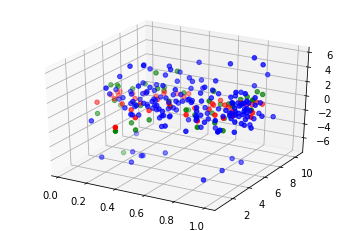

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmhot = plt.get_cmap("hot")
ax.scatter(X2[:,0],X2[:,1],Y2.squeeze(),c='b')
ax.scatter(X2_test[:,0],X2_test[:,1],mean.squeeze(),c='r')
ax.scatter(X2_test[:,0],X2_test[:,1],Y2_truth.squeeze(),c='g')

In [66]:
X = np.random.uniform(0, 10, (200, 1))
f = np.sin(.3*X) + .3*np.cos(1.3*X)
f -= f.mean() #Mean center
Y = f+np.random.normal(0, .1, f.shape) #adding noise
plt.scatter(X,Y)
plt.show()
# fig = plt.figure()
# fig.set_size_inches((5,5))
# ax = fig.add_subplot(111)
# ax.scatter(X,Y)

In [42]:
m = GPy.models.GPRegression(X, Y)
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [45]:
_ = m.plot()

FigureCanvasNbAgg()

In [46]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed

In [65]:
_ = m.plot()

FigureCanvasNbAgg()

In [49]:
m.rbf.lengthscale[:] = 0.1
m

GP_regression.,value,constraints,priors
rbf.variance,0.14007943638325743,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.009878844580201726,+ve,


In [50]:
m.rbf[:] = 0.3
m

GP_regression.,value,constraints,priors
rbf.variance,0.3,+ve,
rbf.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.009878844580201726,+ve,


In [51]:
m.Gaussian_noise[:] = 0.01
m.Gaussian_noise.fix()
m.rbf.lengthscale.constrain_bounded(0.1, 0.5)
m.rbf.variance[:] = 1.0
m

reconstraining parameters GP_regression.rbf.lengthscale


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.3,"0.1,0.5",
Gaussian_noise.variance,0.01,+ve fixed,


In [64]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer
_ = m.plot()
m

FigureCanvasNbAgg()

GP_regression.,value,constraints,priors
rbf.variance,0.1338898377882006,+ve,
rbf.lengthscale,1.4637010518748683,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,0.009879093134513756,+ve,


In [58]:
# Reset model
m.unconstrain()
m[:] = 1.0
m.constrain_positive()
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,1.0,+ve,


In [59]:
# Make a gamma prior and set it as the prior for the lengthscale
gamma_prior = GPy.priors.Gamma.from_EV(1.5, 0.7)
gamma_prior.plot()
m.rbf.lengthscale.set_prior(gamma_prior)
m

 /home/balchlab/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
 /home/balchlab/anaconda3/lib/python3.7/site-packages/GPy/core/parameterization/priors.py:319: RuntimeWarning:invalid value encountered in log
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.lengthscale


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,1.0,+ve,


In [56]:
m.optimize()  # Messages indicates you wish to see the progress of the optimizer
_ = m.plot()
m

FigureCanvasNbAgg()

GP_regression.,value,constraints,priors
rbf.variance,0.13388982382577466,+ve,
rbf.lengthscale,1.463705503747071,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,0.009879260571407967,+ve,
